In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import sys; sys.path.append('../../')
from funcs.xarray_tools import find_cor_ts

from funcs.plotting import map_grid_clean, plt_lc, add_interval
from funcs.snotel import clean_snotel

In [2]:
ds = xr.open_dataset(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsars').joinpath('old/lowman_v2.nc'))
ds = ds.sel(x = slice(-115.3, -115.05), y = slice(44.35, 44.15))
ds = ds.where(~ds['sd'].isel(time = 0).isnull()).dropna('x', how = 'all').dropna('y', how = 'all')
df = pd.read_csv('/Users/rdcrlzh1/Documents/uavsar-coherence/data/snotel/lowman/312:ID:SNTL.csv', parse_dates=True, index_col=0)
df = clean_snotel(df)

In [3]:
ts = find_cor_ts(ds)

In [4]:
# my solition
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [5]:
import matplotlib.colors

class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Combine the lower and upper range of the terrain colormap with a gap in the middle
# to let the coastline appear more prominently.
# inspired by https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 56))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))
# combine them and build a new colormap
colors = np.vstack((colors_undersea, colors_land))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors_land)

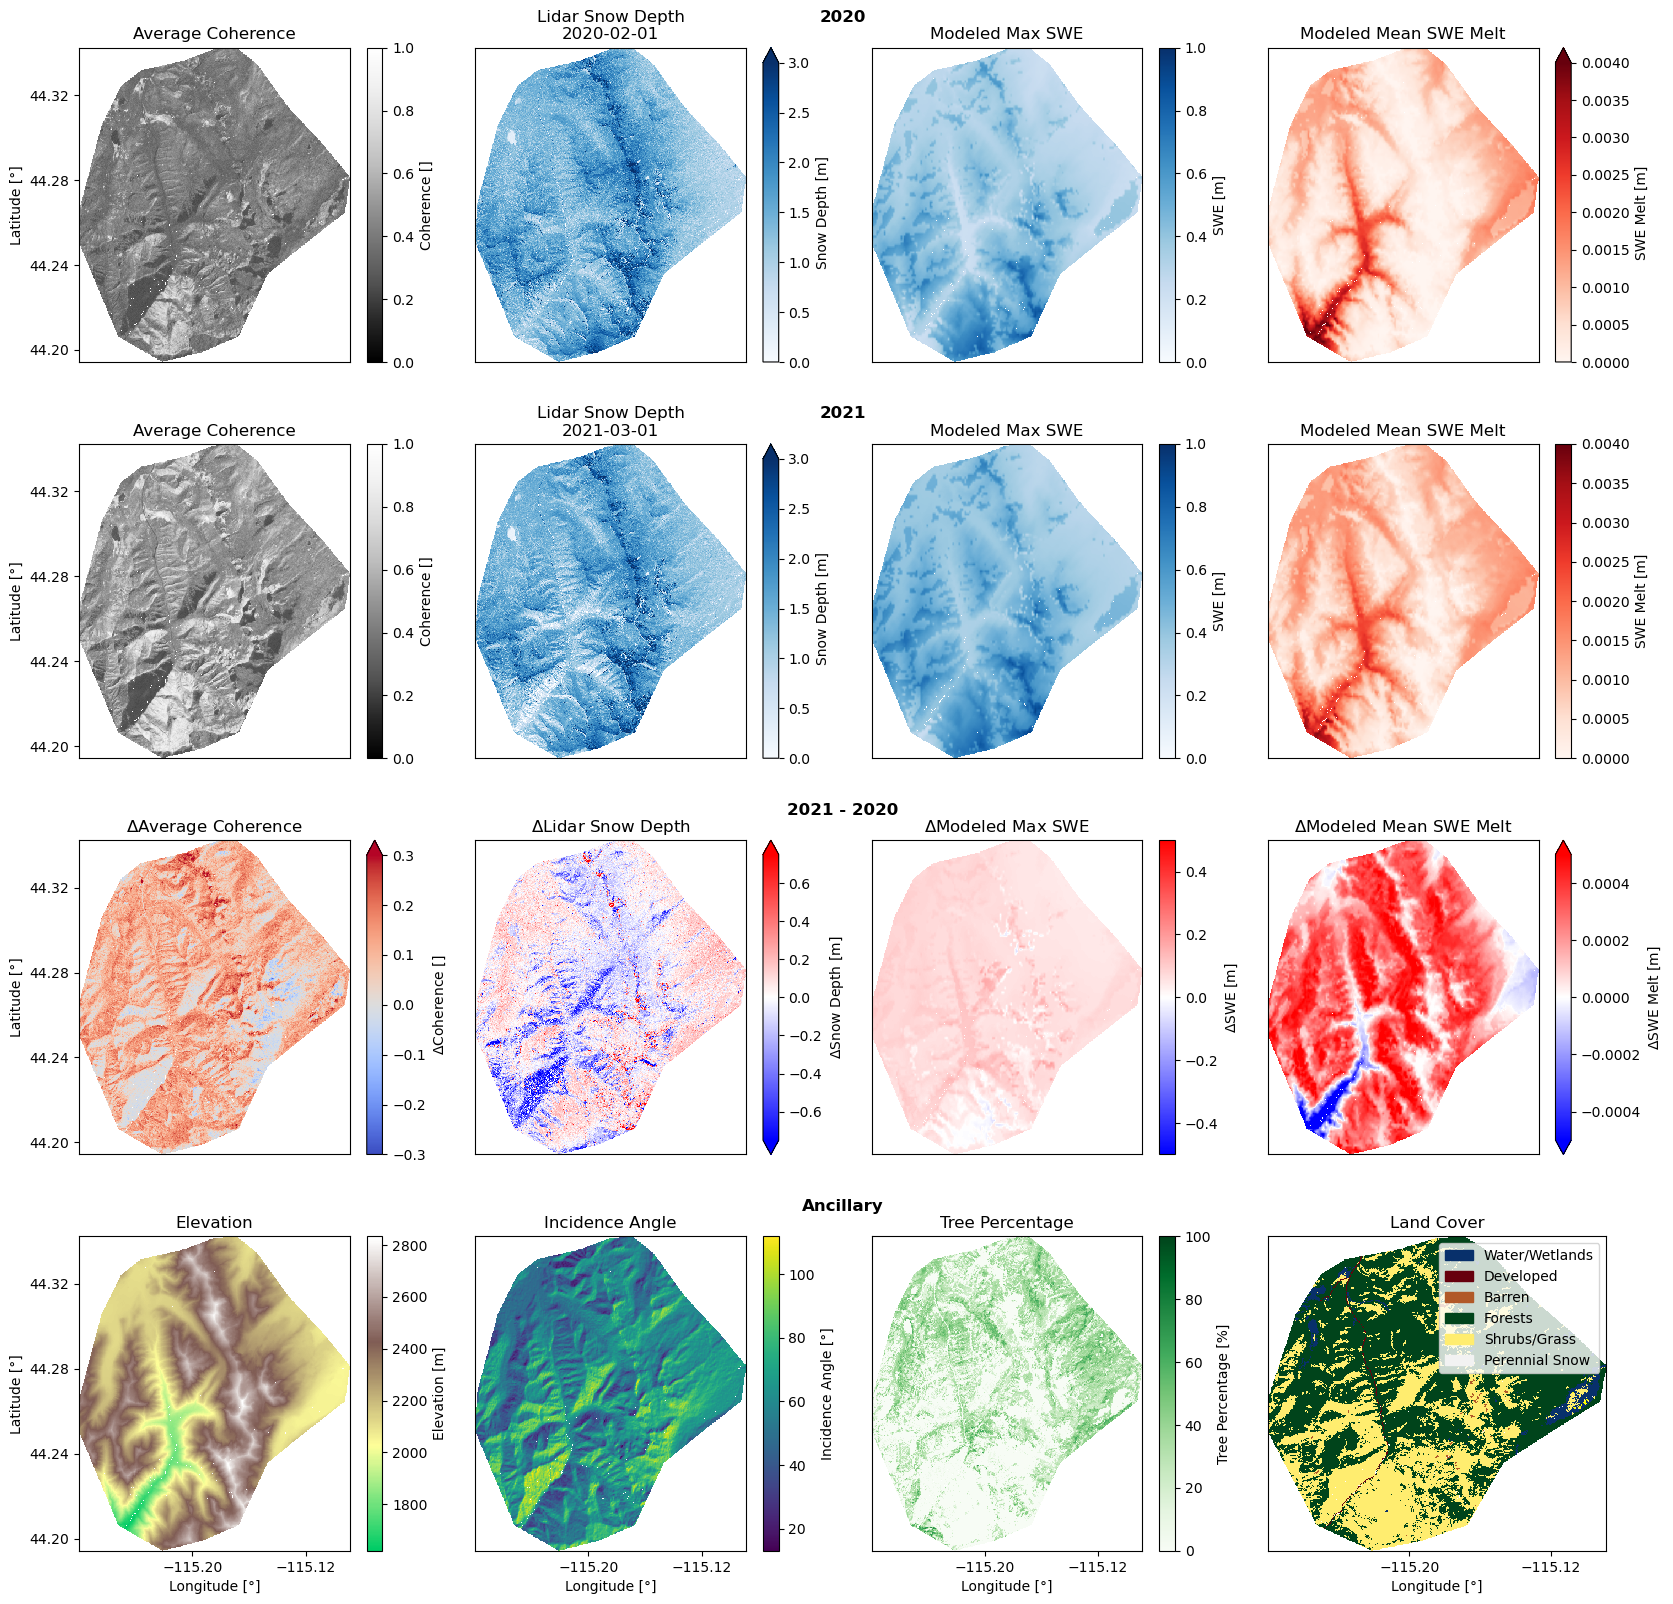

In [12]:
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
grid = plt.GridSpec(rows, cols)
create_subtitle(fig, grid[0, ::], '2020')
create_subtitle(fig, grid[1, ::], '2021')
create_subtitle(fig, grid[2, ::], '2021 - 2020')
create_subtitle(fig, grid[3, ::], 'Ancillary')

fig.tight_layout()
fig.set_facecolor('w')

ds['cor'].sel(pol = 'VV', heading = 232).sel(time1 = slice('2019-12-01', '2020-04-01'), time2 = slice('2019-12-01', '2020-04-01')).mean(['time1', 'time2']).plot(ax = axes[0, 0], cmap = 'Greys_r', vmin = 0, vmax = 1, cbar_kwargs = {'label': 'Coherence []'})
ds['sd'].isel(time = 0).plot(vmax = 3, cmap = 'Blues', ax = axes[0, 1],  vmin = 0, cbar_kwargs = {'label': 'Snow Depth [m]'})
ds['model_swe'].sel(model_time = slice('2019-12-01', '2020-04-01')).max('model_time').plot(ax = axes[0, 2], cbar_kwargs = {'label': 'SWE [m]'}, vmin = 0, vmax = 1, cmap = 'Blues')
ds['model_melt'].sel(model_time = slice('2019-12-01', '2020-04-01')).mean('model_time').plot(ax = axes[0, 3], vmin = 0, vmax = 0.004, cbar_kwargs = {'label': 'SWE Melt [m]'}, cmap = 'Reds')

ds['cor'].sel(pol = 'VV', heading = 232).sel(time1 = slice('2020-12-01', '2021-04-01'), time2 = slice('2020-12-01', '2021-04-01')).mean(['time1', 'time2']).plot(ax = axes[1, 0], cmap = 'Greys_r', vmin = 0, vmax = 1, cbar_kwargs = {'label': 'Coherence []'})
ds['sd'].isel(time = 1).plot(vmax = 3, cmap = 'Blues', ax = axes[1, 1],  vmin = 0, cbar_kwargs = {'label': 'Snow Depth [m]'})
ds['model_swe'].sel(model_time = slice('2020-12-01', '2021-04-01')).max('model_time').plot(ax = axes[1, 2], cbar_kwargs = {'label': 'SWE [m]'}, vmin = 0, vmax = 1, cmap = 'Blues')
ds['model_melt'].sel(model_time = slice('2020-12-01', '2021-04-01')).mean('model_time').plot(ax = axes[1, 3], vmin = 0, vmax = 0.004, cbar_kwargs = {'label': 'SWE Melt [m]'}, cmap = 'Reds')

for axr in axes[:2, :]:
    for ax, title in zip(axr, ['Average Coherence', 'Lidar Snow Depth', 'Modeled Max SWE', 'Modeled Mean SWE Melt']):
        ax.set_title(title)

axes[0, 1].set_title('Lidar Snow Depth\n2020-02-01')
axes[1, 1].set_title('Lidar Snow Depth\n2021-03-01')

(ds['cor'].sel(pol = 'VV', heading = 232).sel(time1 = slice('2020-12-01', '2021-04-01'), time2 = slice('2020-12-01', '2021-04-01')).mean(['time1', 'time2']) - \
    ds['cor'].sel(pol = 'VV', heading = 232).sel(time1 = slice('2019-12-01', '2020-04-01'), time2 = slice('2019-12-01', '2020-04-01')).mean(['time1', 'time2']))\
        .plot(ax = axes[2, 0], cmap = 'coolwarm', vmin = -0.3, vmax = 0.3, cbar_kwargs = {'label': '$\\Delta$Coherence []'})

(ds['sd'].isel(time = 1) - ds['sd'].isel(time = 0)).plot(vmax = 0.75, cmap = 'bwr', ax = axes[2, 1],  vmin = -0.75, cbar_kwargs = {'label': '$\\Delta$Snow Depth [m]'})

(ds['model_swe'].sel(model_time = slice('2020-12-01', '2021-04-01')).max('model_time') - ds['model_swe'].sel(model_time = slice('2019-12-01', '2020-04-01')).max('model_time')).plot(vmax = 0.5, cmap = 'bwr', ax = axes[2, 2],  vmin = -0.5, cbar_kwargs = {'label': '$\\Delta$SWE [m]'})
(ds['model_melt'].sel(model_time = slice('2020-12-01', '2021-04-01')).mean('model_time') - ds['model_melt'].sel(model_time = slice('2019-12-01', '2020-04-01')).mean('model_time')).plot(vmax = 0.0005, cmap = 'bwr', ax = axes[2, 3],  vmin = -0.0005, cbar_kwargs = {'label': '$\\Delta$SWE Melt [m]'})

for ax, title in zip(axes[2, :], ['$\\Delta$Average Coherence', '$\\Delta$Lidar Snow Depth', '$\\Delta$Modeled Max SWE', '$\\Delta$Modeled Mean SWE Melt']):
    ax.set_title(title)

ds['dem'].plot(ax = axes[3, 0], cmap = cut_terrain_map, cbar_kwargs = {'label': 'Elevation [m]'})
np.rad2deg(ds['inc']).sel(heading = 232).plot(ax = axes[3, 1], cbar_kwargs = {'label': 'Incidence Angle [°]'})
ds['tree_perc'].plot(ax = axes[3, 2], cmap = 'Greens', vmin = 0, vmax = 100, cbar_kwargs = {'label': 'Tree Percentage [%]'})
plt_lc(ds['land_cover'], axes[3, 3])

for ax, title in zip(axes[3, :], ['Elevation', 'Incidence Angle', 'Tree Percentage', 'Land Cover']):
    ax.set_title(title)

map_grid_clean(axes)
fig_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/figures/examples')
plt.savefig(fig_dir.joinpath('banner_ex20_21.png'))